# Analysis 

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, sum, avg, format_number, mean, month, unix_timestamp, date_format, when, round, log, expr
from pyspark.sql.types import DateType

import warnings
warnings.filterwarnings('ignore')

In [32]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 ")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

### import taxi data

In [33]:
tlc_sdf = spark.read.parquet('../data/curated/taxi_data/*')

In [34]:
tlc_sdf.count()

35960309

### Import the gasoline data

In [35]:
gasoline_df = pd.read_csv("../data/curated/gasoline_data/gasoline_data_2018.csv")
gasoline_sdf = spark.createDataFrame(gasoline_df)


Merge the two data 

In [36]:
# full_sdf denotes full data
full_sdf = tlc_sdf.join(gasoline_sdf, on=['week_number'], how='inner')

### sample 5% of taxi data for visualisation


In [7]:
# Randomly sample 0.5% of the records for visualisation
sampled_sdf = full_sdf.sample(fraction=0.05, seed=1)  # Using a seed for reproducibility
sampled_sdf.count()

1796446

# Preliminary data analysis
## Focusing key metric from tlc taxi data and weekly gasoline price in new york 

## Examine the numeric feature distribution
### using the sampled data for visualisation 

In [8]:
# Select the columns for analysis
data = sampled_sdf
columns_to_plot = ['trip_distance', 'trip_duration_minutes', 'tip_amount', 'fare_amount']

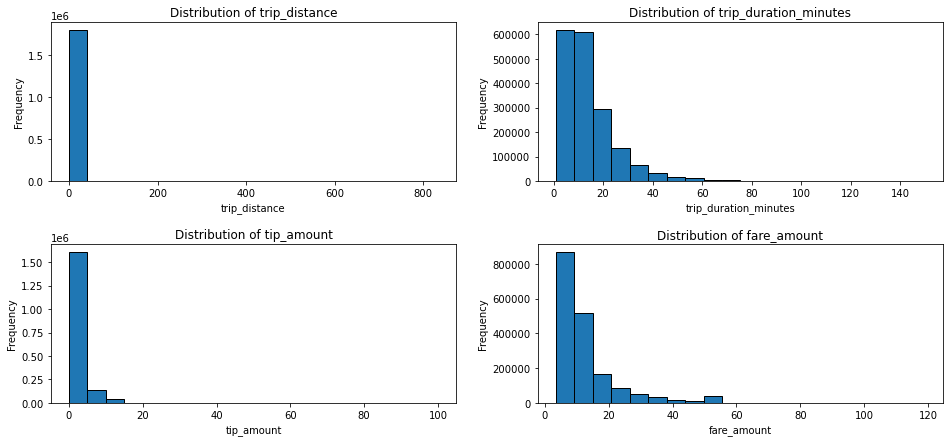

In [9]:
# Define the number of rows and columns for subplots
num_rows = 2
num_cols = 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 7),gridspec_kw={'hspace': 0.4, 'wspace': 0.2})
fig.tight_layout()

# Loop through each column and plot its distribution in a subplot
for i, column in enumerate(columns_to_plot):
    # Filter out NULL values
    # Convert the filtered data to a Pandas DataFrame for plotting
    pandas_data = data.select(column).toPandas()

    # Plot the histogram in the corresponding subplot
    ax = axs[i // num_cols, i % num_cols]
    ax.hist(pandas_data[column], bins=20, edgecolor='black')
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

output_image_path = "../plots/distribution.png"
plt.savefig(output_image_path)
# Show the subplots
plt.show()


#### notice there is right skewness the distribution, we will apply log transformation to the sample 

In [10]:
# aware here data is refering to the sample data 
# Apply log transformation to the specified columns
data = data.withColumn('trip_distance_log', log(data['trip_distance']))
data = data.withColumn('tip_amount_log', log(data['tip_amount'] +1))
data = data.withColumn('fare_amount_log', log(data['fare_amount']))
data = data.withColumn('trip_duration_minutes_log', log(data['trip_duration_minutes']))

data = data.drop(*['trip_distance', 'tip_amount', 'fare_amount', 'trip_duration_minutes'])


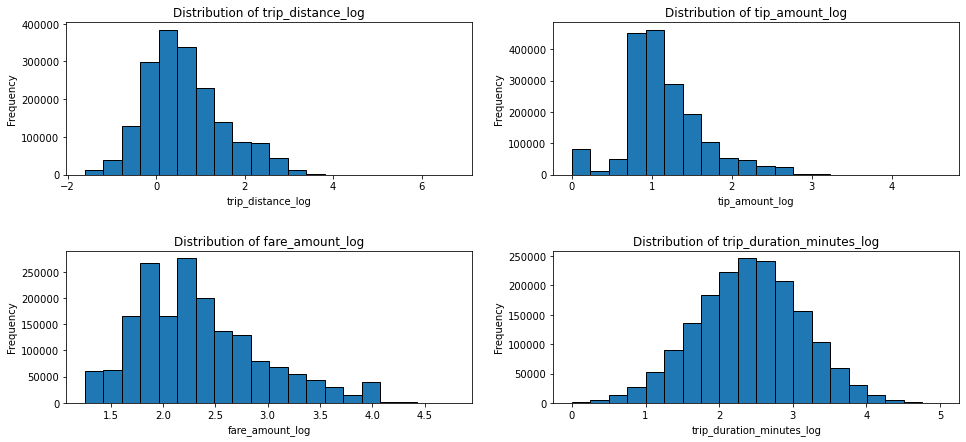

In [11]:
# now plot the data again 
# Define the number of rows and columns for subplots
num_rows = 2
num_cols = 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 7),gridspec_kw={'hspace': 0.5, 'wspace': 0.2})
fig.tight_layout()

columns_to_plot = ['trip_distance_log', 'tip_amount_log', 'fare_amount_log', 'trip_duration_minutes_log']

# Loop through each column and plot its distribution in a subplot
for i, column in enumerate(columns_to_plot):
    
    # Convert the filtered data to a Pandas DataFrame for plotting
    pandas_data = data.select(column).toPandas()

    # Plot the histogram in the corresponding subplot
    ax = axs[i // num_cols, i % num_cols]
    ax.hist(pandas_data[column], bins=20, edgecolor='black')
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
# save to plots folder
output_image_path = "../plots/loged_distribution.png"
plt.savefig(output_image_path)


Since the log transformation improves the distribution of these numeric metrics
we will also apply log transformation to the full data set 

In [12]:
# also appply log transofrmation to features in the full dataset 

full_sdf = full_sdf.withColumn('trip_distance_log', log(full_sdf['trip_distance']))
full_sdf = full_sdf.withColumn('tip_amount_log', log(full_sdf['tip_amount']))
full_sdf = full_sdf.withColumn('fare_amount_log', log(full_sdf['fare_amount']))
full_sdf = full_sdf.withColumn('trip_duration_minutes_log', log(full_sdf['trip_duration_minutes']))

full_sdf = full_sdf.drop(*['trip_distance', 'tip_amount', 'fare_amount', 'trip_duration_minutes'])


Due to the significant number of record in the full_sdf, we are unable to examine the correlation coefficient between each attribute by the full data. therefore, we will estimate the correlation coefficient of the attribute with the 5% sample data 

In [13]:
# drip the categorical features 
correlation_matrix =data.drop(*['day_of_the_week', 'period' , 'pickup_day', 'passenger_count']).toPandas().corr()

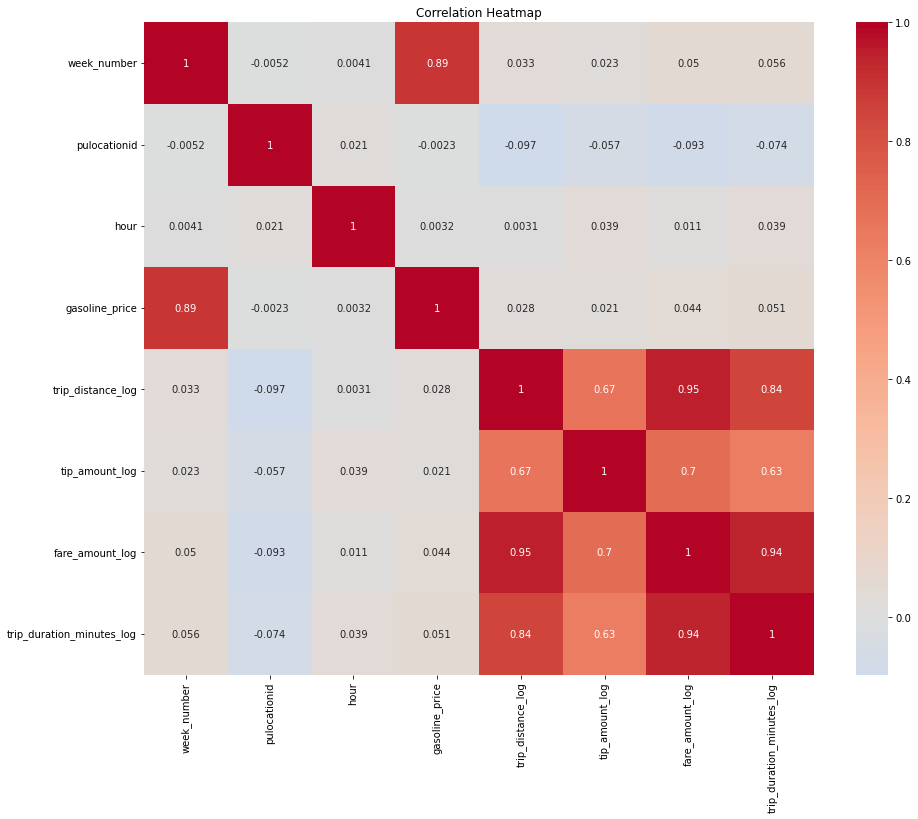

In [14]:
# Plot heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
output_image_path = "../plots/correlation_heatmap.png"
plt.savefig(output_image_path)

plt.show()

## Hourly Analysis

In [15]:
# Group by the hour of the day and calculate the average trip duration and tip amount
#gb_hour denotes group by hours
gb_hour = full_sdf.groupBy("hour").agg(
    F.avg("trip_distance_log").alias("avg_trip_distance_log"),
    F.avg("tip_amount_log").alias("avg_tip_amount_log"),
    F.count("*").alias("trip_count"),
    F.avg("fare_amount_log").alias("avg_fare_amount_log") # 
)



Fixing the number of decimal places for some numeric features

In [16]:
gb_hour = gb_hour.withColumn(
    "avg_trip_distance_log", round(F.col("avg_trip_distance_log"), 4)
).withColumn(
    "avg_tip_amount_log", round(F.col("avg_tip_amount_log"), 4)
).withColumn(
    "avg_fare_amount_log", round(F.col("avg_fare_amount_log"), 4)
)


In [17]:
# Order the data by hour  
gb_hour= gb_hour.orderBy("hour")

In [23]:
# Convert PySpark DataFrame to Pandas DataFrame for plotting
pandas_data = gb_hour.toPandas()


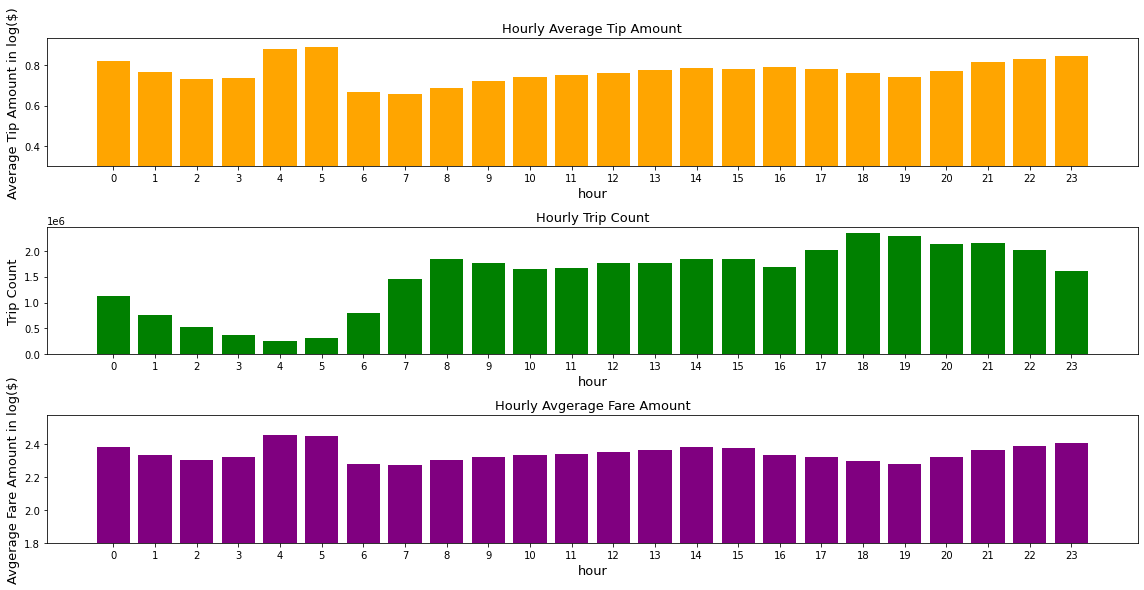

In [30]:
# Create a 2x2 subplot
fig, axs = plt.subplots(3, 1, figsize=(16, 8))

# Plot Average Trip Duration
#axs[0, 0].bar(pandas_data["hour"], pandas_data["avg_trip_distance_log"])
#axs[0, 0].set_title("Hourly Average Trip Distance")
#axs[0, 0].set_xlabel("Hour")
#axs[0, 0].set_ylabel("Average Trip distance in log(mile) ")
#axs[0, 0].set_xticks(range(0, 25))


# Plot Average Tip Amount
axs[0].bar(pandas_data["hour"], pandas_data["avg_tip_amount_log"], color="orange")
axs[0].set_title("Hourly Average Tip Amount",fontsize=13)
axs[0].set_xlabel("hour",fontsize=13)
axs[0].set_ylabel("Average Tip Amount in log($)",fontsize=13)
axs[0].set_ylim(0.3, None)
axs[0].set_xticks(range(0, 24))

# Plot Trip Count
axs[1].bar(pandas_data["hour"], pandas_data["trip_count"], color="green")
axs[1].set_title("Hourly Trip Count",fontsize=13)
axs[1].set_xlabel("hour",fontsize=13)
axs[1].set_ylabel("Trip Count",fontsize=13)
axs[1].set_xticks(range(0, 24))

# Plot fare
axs[2].bar(pandas_data["hour"], pandas_data["avg_fare_amount_log"], color="purple")
axs[2].set_title("Hourly Avgerage Fare Amount",fontsize=13)
axs[2].set_xlabel("hour",fontsize=13)
axs[2].set_ylabel("Avgerage Fare Amount in log($)",fontsize=13)
axs[2].set_ylim(1.8, None)  # since fare amount>=0, ==> log(fare)>1.1
axs[2].set_xticks(range(0, 24))

# Adjust layout
plt.tight_layout()

output_image_path = "../plots/hourly_analysis.png"
plt.savefig(output_image_path)

plt.show()






## Weekly analysis

In [20]:
# Group by the week number and calculate the average trip distance, tip amount....
# let gb_week denote group by week 
gb_week = full_sdf.groupBy("week_number").agg(
    F.avg("fare_amount_log").alias("avg_fare_amount_log"),
    F.avg("tip_amount_log").alias("avg_tip_amount_log"),
    F.count("*").alias("trip_count"),
    F.avg("gasoline_price").alias("average_gasoline_price")
)



In [21]:
pandas_data = gb_week.orderBy("week_number").toPandas()

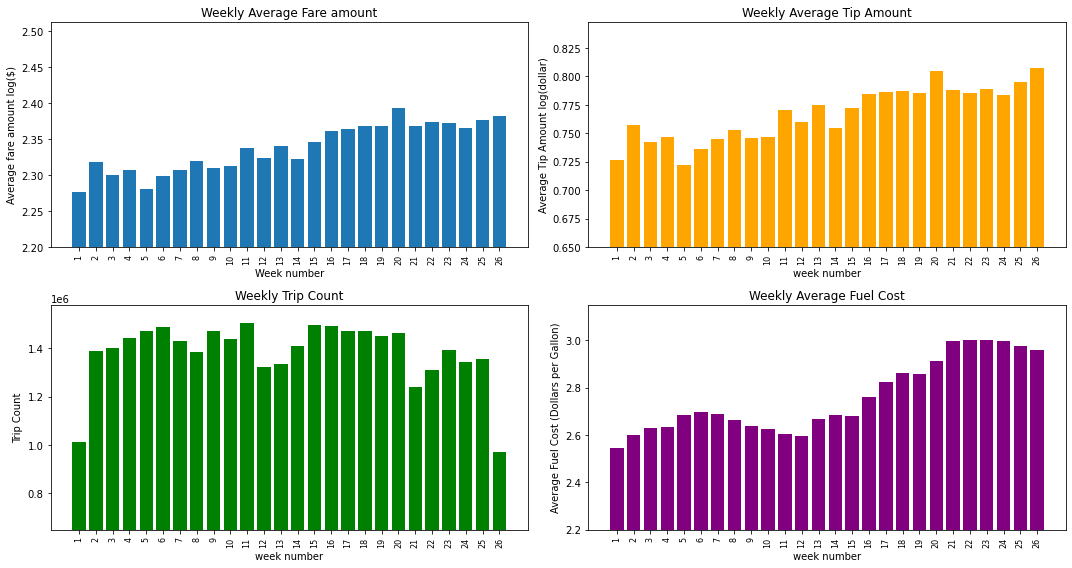

In [22]:

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(15, 8))

# Plot Average Trip Duration
axs[0, 0].bar(pandas_data["week_number"], pandas_data["avg_fare_amount_log"])
axs[0, 0].set_title("Weekly Average Fare amount")
axs[0, 0].set_xlabel("Week number")
axs[0, 0].set_ylabel("Average fare amount log($)")
axs[0, 0].set_xticks(range(1, 27))
axs[0, 0].set_xticklabels(range(1, 27), rotation='vertical',fontsize=8)  # Rotate x-axis labels vertically
axs[0, 0].set_ylim(2.2, None)


# Plot Average Tip Amount
axs[0, 1].bar(pandas_data["week_number"], pandas_data["avg_tip_amount_log"], color="orange")
axs[0, 1].set_title("Weekly Average Tip Amount")
axs[0, 1].set_xlabel("week number")
axs[0, 1].set_ylabel("Average Tip Amount log(dollar)")
axs[0, 1].set_xticks(range(1, 27))
axs[0, 1].set_xticklabels(range(1, 27), rotation='vertical', fontsize=8)  # Rotate x-axis labels vertically
axs[0, 1].set_ylim(0.65, None) 

# Plot Trip Count
axs[1, 0].bar(pandas_data["week_number"], pandas_data["trip_count"], color="green")
axs[1, 0].set_title("Weekly Trip Count")
axs[1, 0].set_xlabel("week number")
axs[1, 0].set_ylabel("Trip Count")
axs[1, 0].set_ylim(650000, None) 
axs[1, 0].set_xticks(range(1, 27))
axs[1, 0].set_xticklabels(range(1, 27), rotation='vertical', fontsize=8)  # Rotate x-axis labels vertically

# Plot Fule cost
axs[1, 1].bar(pandas_data["week_number"], pandas_data["average_gasoline_price"], color="purple")
axs[1, 1].set_title("Weekly Average Fuel Cost")
axs[1, 1].set_xlabel("week number")
axs[1, 1].set_ylabel("Average Fuel Cost (Dollars per Gallon)")
axs[1, 1].set_xticks(range(1, 27))
axs[1, 1].set_xticklabels(range(1, 27), rotation='vertical',fontsize=8)  # Rotate x-axis labels vertically
axs[1, 1].set_ylim(2.2, None) 

# Adjust layout
plt.tight_layout()

output_image_path = "../plots/weekly_analysis.png"
plt.savefig(output_image_path)
plt.show()
